Data Loading & Preparation

In [5]:
import os
import sys
import pandas as pd
sys.path.append(os.path.abspath('../scripts'))

# Change the current working directory to the appropriate path
os.chdir('/home/semre/telecom_user_behaviour_analysis')

In [2]:
# Import the required functions and modules
from src.utils import missing_values_table
from data_loader import load_data_from_db
# Call the function to load data
query = "SELECT * FROM public.xdr_data"
df = load_data_from_db(query)

Host: localhost, Port: 5432, DB: telecom_db, User: postgres


In [3]:
# Preview the dataset
df.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


Convert Columns to Appropriate Data Types

In [6]:
# Convert 'Start' and 'End' columns to datetime
df['Start'] = pd.to_datetime(df['Start'], errors='coerce')
df['End'] = pd.to_datetime(df['End'], errors='coerce')

# Ensure that numerical columns are correctly formatted
numeric_cols = [
    'Dur. (ms)', 'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 
    'Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)',
    'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)',
    'Other DL (Bytes)', 'Total UL (Bytes)', 'Total DL (Bytes)'
]

# Convert to numeric, coercing errors
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Display data types to confirm changes
print(df.dtypes)

Bearer Id                                          float64
Start                                       datetime64[ns]
Start ms                                           float64
End                                         datetime64[ns]
End ms                                             float64
Dur. (ms)                                          float64
IMSI                                               float64
MSISDN/Number                                      float64
IMEI                                               float64
Last Location Name                                  object
Avg RTT DL (ms)                                    float64
Avg RTT UL (ms)                                    float64
Avg Bearer TP DL (kbps)                            float64
Avg Bearer TP UL (kbps)                            float64
TCP DL Retrans. Vol (Bytes)                        float64
TCP UL Retrans. Vol (Bytes)                        float64
DL TP < 50 Kbps (%)                                float

Handle Missing Values

In [7]:
missing_values_df = missing_values_table(df)
print("Missing Values in df:")
print(missing_values_df)

Your selected dataframe has 55 columns
There are 41 columns that have missing values.
Missing Values in df:
                                          mis_val  % of Total Values  \
Nb of sec with 37500B < Vol UL             130254               86.8   
Nb of sec with 6250B < Vol UL < 37500B     111843               74.6   
Nb of sec with 125000B < Vol DL             97538               65.0   
TCP UL Retrans. Vol (Bytes)                 96649               64.4   
Nb of sec with 31250B < Vol DL < 125000B    93586               62.4   
Nb of sec with 1250B < Vol UL < 6250B       92894               61.9   
Nb of sec with 6250B < Vol DL < 31250B      88317               58.9   
TCP DL Retrans. Vol (Bytes)                 88146               58.8   
HTTP UL (Bytes)                             81810               54.5   
HTTP DL (Bytes)                             81474               54.3   
Avg RTT DL (ms)                             27829               18.6   
Avg RTT UL (ms)             

#### Aggregate Metrics per Customer

In [12]:
# Aggregate metrics per customer id (MSISDN)
engagement_metrics = df.groupby('MSISDN/Number').agg({
    'Dur. (ms)': 'sum',
    'HTTP DL (Bytes)': 'sum',
    'HTTP UL (Bytes)': 'sum',
    'Total DL (Bytes)': 'sum',
    'Total UL (Bytes)': 'sum'
}).reset_index()

# Adding a total traffic column
engagement_metrics['Total Traffic (Bytes)'] = engagement_metrics['HTTP DL (Bytes)'] + engagement_metrics['HTTP UL (Bytes)']

# Display the first few rows of the aggregated metrics
print(engagement_metrics.head())

   MSISDN/Number  Dur. (ms)  HTTP DL (Bytes)  HTTP UL (Bytes)  \
0   3.360100e+10   116720.0     1.144710e+08     3.242301e+06   
1   3.360100e+10   181230.0     1.144710e+08     3.242301e+06   
2   3.360100e+10   134969.0     1.144710e+08     3.242301e+06   
3   3.360101e+10    49878.0     8.749000e+03     6.530000e+02   
4   3.360101e+10    37104.0     2.996791e+08     7.976119e+06   

   Total DL (Bytes)  Total UL (Bytes)  Total Traffic (Bytes)  
0      8.426375e+08        36053108.0           1.177133e+08  
1      1.207552e+08        36104459.0           1.177133e+08  
2      5.566597e+08        39306820.0           1.177133e+08  
3      4.019932e+08        20327526.0           9.402000e+03  
4      1.363130e+09        94280527.0           3.076552e+08  


#### Normalize Engagement Metrics

In [13]:
from sklearn.preprocessing import StandardScaler

# Normalize engagement metrics
scaler = StandardScaler()
scaled_metrics = scaler.fit_transform(engagement_metrics[['Dur. (ms)', 'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Total Traffic (Bytes)']])
engagement_metrics[['Dur. (ms)', 'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Total Traffic (Bytes)']] = scaled_metrics

# Display the first few rows of normalized metrics
print(engagement_metrics.head())

   MSISDN/Number  Dur. (ms)  HTTP DL (Bytes)  HTTP UL (Bytes)  \
0   3.360100e+10  -0.158014        -0.055549        -0.068235   
1   3.360100e+10   0.188148        -0.055549        -0.068235   
2   3.360100e+10  -0.060090        -0.055549        -0.068235   
3   3.360101e+10  -0.516690        -0.194565        -0.239156   
4   3.360101e+10  -0.585235         0.169388         0.181362   

   Total DL (Bytes)  Total UL (Bytes)  Total Traffic (Bytes)  
0      8.426375e+08        36053108.0              -0.056339  
1      1.207552e+08        36104459.0              -0.056339  
2      5.566597e+08        39306820.0              -0.056339  
3      4.019932e+08        20327526.0              -0.197335  
4      1.363130e+09        94280527.0               0.171189  


#### Perform K-Means Clustering

In [14]:
from sklearn.cluster import KMeans

# Perform k-means clustering (k=3)
kmeans = KMeans(n_clusters=3, random_state=42)
engagement_metrics['Cluster'] = kmeans.fit_predict(scaled_metrics)

# Compute and print statistics for each cluster
cluster_stats = engagement_metrics.groupby('Cluster').agg({
    'Dur. (ms)': ['min', 'max', 'mean'],
    'HTTP DL (Bytes)': ['min', 'max', 'mean'],
    'HTTP UL (Bytes)': ['min', 'max', 'mean'],
    'Total Traffic (Bytes)': ['min', 'max', 'mean']
})

print(cluster_stats)

        Dur. (ms)                      HTTP DL (Bytes)                        \
              min        max      mean             min        max       mean   
Cluster                                                                        
0       -0.746012  98.775512 -0.000192       -0.194576  20.017994  -0.016252   
1       -0.483179   1.980984  0.362879       19.466997  87.894591  39.469483   
2       -0.320723   1.533769  0.412665       -0.178661  17.029382   3.208638   

        HTTP UL (Bytes)                        Total Traffic (Bytes)  \
                    min         max       mean                   min   
Cluster                                                                
0             -0.239189   29.238397  -0.014971             -0.197346   
1              0.286685   66.757131  20.377244             19.475724   
2             32.165624  117.041702  60.228546              0.897661   

                               
               max       mean  
Cluster               

#### Aggregate and Plot Top Applications

Top 10 users for Social Media:
 MSISDN/Number
3.362632e+10    42743837.0
3.376054e+10    39297646.0
3.365973e+10    34900444.0
3.361489e+10    27749744.0
3.362578e+10    26564121.0
3.366716e+10    23753753.0
3.378632e+10    23568655.0
3.366907e+10    23477047.0
3.360313e+10    22776679.0
3.365849e+10    22695673.0
Name: Social Media DL (Bytes), dtype: float64
Top 10 users for Google:
 MSISDN/Number
3.362632e+10    116106455.0
3.362578e+10    107904739.0
3.361489e+10     93941708.0
3.365973e+10     90958549.0
3.376054e+10     88626532.0
3.367588e+10     83002994.0
3.378632e+10     78819810.0
3.360313e+10     73942055.0
3.376127e+10     72949803.0
3.366716e+10     71707826.0
Name: Google DL (Bytes), dtype: float64
Top 10 users for Email:
 MSISDN/Number
3.361489e+10    33607211.0
3.362632e+10    33404785.0
3.362578e+10    31895412.0
3.378632e+10    30876908.0
3.365973e+10    29907647.0
3.376054e+10    26437895.0
3.366546e+10    25942871.0
3.367588e+10    24284723.0
3.369879e+10    2416559

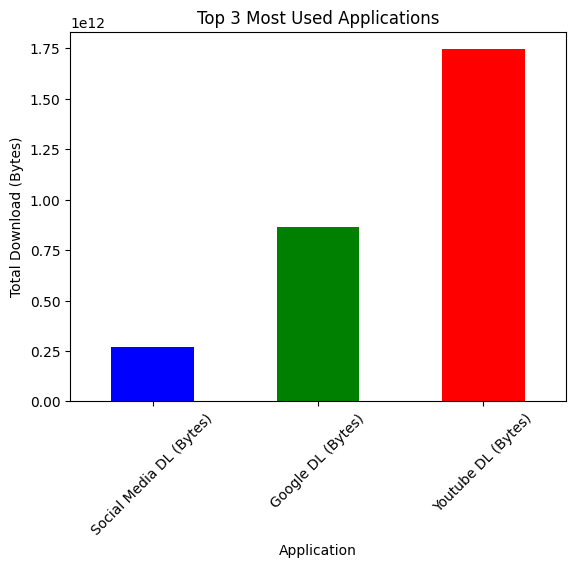

In [15]:
# Define top applications
top_applications = {
    'Social Media DL (Bytes)': 'Social Media',
    'Google DL (Bytes)': 'Google',
    'Email DL (Bytes)': 'Email',
    'Youtube DL (Bytes)': 'YouTube',
    'Netflix DL (Bytes)': 'Netflix',
    'Gaming DL (Bytes)': 'Gaming',
    'Other DL (Bytes)': 'Other'
}

# Aggregate top 10 users per application
for app_col, app_name in top_applications.items():
    top_users = df.groupby('MSISDN/Number')[app_col].sum().nlargest(10)
    print(f"Top 10 users for {app_name}:\n", top_users)

# Plot the top 3 most used applications
top_apps_df = df[['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Youtube DL (Bytes)']].sum()
top_apps_df.plot(kind='bar', color=['blue', 'green', 'red'])
plt.title('Top 3 Most Used Applications')
plt.xlabel('Application')
plt.ylabel('Total Download (Bytes)')
plt.xticks(rotation=45)
plt.show()

#### Determine Optimal Number of Clusters Using the Elbow Method

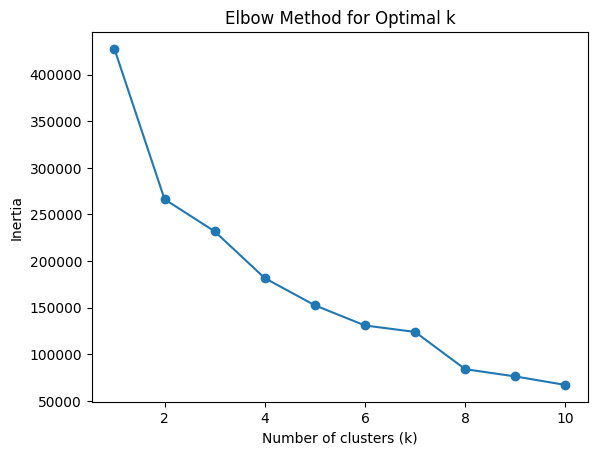

In [16]:
# Determine the optimal value of k using the elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_metrics)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.show()